In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

iris = datasets.load_iris()
X = iris.data 
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

<Figure size 800x600 with 1 Axes>

In [2]:
from Dotua.rautodiff import rAutoDiff as rad
from Dotua.roperator import rOperator as op
import random

rad = rad()

class NeuralNetwork():
    def __init__(self, input_vals, input_bias, hidden_bias, num_hidden, output, learning_rate = 0.1):
        self.input_vals = input_vals
        self.input_bias = input_bias
        self.hidden_bias = hidden_bias
        self.num_hidden = num_hidden
        self.output = output
        self.learning_rate = learning_rate

        self.weights_tohidden = [None] * num_hidden
        for i in range(num_hidden):
            self.weights_tohidden[i] = []
            for j in range(len(input_vals)):
                
                #DOTUA USED HERE: to initalize the weights from the input to hidden layer.
                w = rad.create_rscalar(random.random())
                self.weights_tohidden[i].append(w)
                self.weights_tooutput = [None] * len(output)
        
        for i in range(len(output)):
            self.weights_tooutput[i] = []
            
            #DOTUA USED HERE: to initialize weights from hidden to output.
            w = rad.create_rscalar(random.random())
            for j in range(num_hidden):
                self.weights_tooutput[i].append(w)

    def train(self, input_vals, output_vals):
        self.input_vals = input_vals
        self.output = output_vals

        #calculation of hidden layer.
        self.hidden_layer = []
        for i in range(self.num_hidden):
            h = 0
            for j in range(len(self.weights_tohidden[i])):
                h = h + self.weights_tohidden[i][j] * self.input_vals[j]
            h = h + self.input_bias
            self.hidden_layer.append(1/(1+op.exp(-h)))

        # To calculate the output layer neurons and error
        error = 0
        for i in range(len(self.output)):
            o = 0
            for j in range(len(self.weights_tooutput[i])):
                o = o + self.weights_tooutput[i][j] * self.hidden_layer[j]
            o = o + self.hidden_bias
            o = 1/(1+op.exp(-o))
            error = error + (o - self.output[i]) ** 2

        # To update weights from hidden layer to output layer
        for i in range(len(self.weights_tooutput)):
            for j in range(len(self.weights_tooutput[i])):
                
                #DOTUA USED HERE:
                d = rad.partial(error, self.weights_tooutput[i][j])
                self.weights_tooutput[i][j] = self.weights_tooutput[i][j] - d * self.learning_rate

        # To update weights from input layer to hidden layer
        for i in range(len(self.weights_tohidden)):
            for j in range(len(self.weights_tooutput[i])):
                
                #DOTUA USED HERE:
                d = rad.partial(error, self.weights_tohidden[i][j])
                self.weights_tohidden[i][j] = self.weights_tohidden[i][j] - d * self.learning_rate

    def predict(self, input_vals, output_vals):
        self.input_vals = input_vals
        self.output = output_vals

        # To calculate the hidden layer neurons using the current model
        self.hidden_layer = []
        for i in range(self.num_hidden):
            h = 0
            for j in range(len(self.weights_tohidden[i])):
                h = h + self.weights_tohidden[i][j] * self.input_vals[j]
            h = h + self.input_bias
            self.hidden_layer.append(1/(1+op.exp(-h)))

        # To calculate the output layer neurons using the current model and calculate the error 
        error = 0
        output_layer = []
        for i in range(len(self.output)):
            o = 0
            for j in range(len(self.weights_tooutput[i])):
                o = o + self.weights_tooutput[i][j] * self.hidden_layer[j]
            o = o + self.hidden_bias
            o = 1/(1+op.exp(-o))
            output_layer.append(o.val)
            error = error + (o - self.output[i]) ** 2
        error = error / len(self.output)
        return (output_layer, error.val)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=64)

In [4]:
import numpy as np
def get_y(i):
    train_y = [0,0,0]
    train_y[i] = 1
    return train_y

nn = NeuralNetwork([0,0,0],0.33,0.33,2,[0,0,0])

for j in range(10):
    for i in range(1, len(X_train)):
        nn.train(X_train[i], get_y(y_train[i]))

train_e = []
true_y = []
predicted_y = []
for i in range(1, len(X_train)):
    output,e = nn.predict(X_train[i], get_y(y_train[i]))
    train_e.append(e)
    #print(e)
    if max(output) == output[0]:
        predicted_y.append(0)
    elif max(output) == output[1]:
        predicted_y.append(1)
    else:
        predicted_y.append(2)
    
    true_y.append(y_train[i])

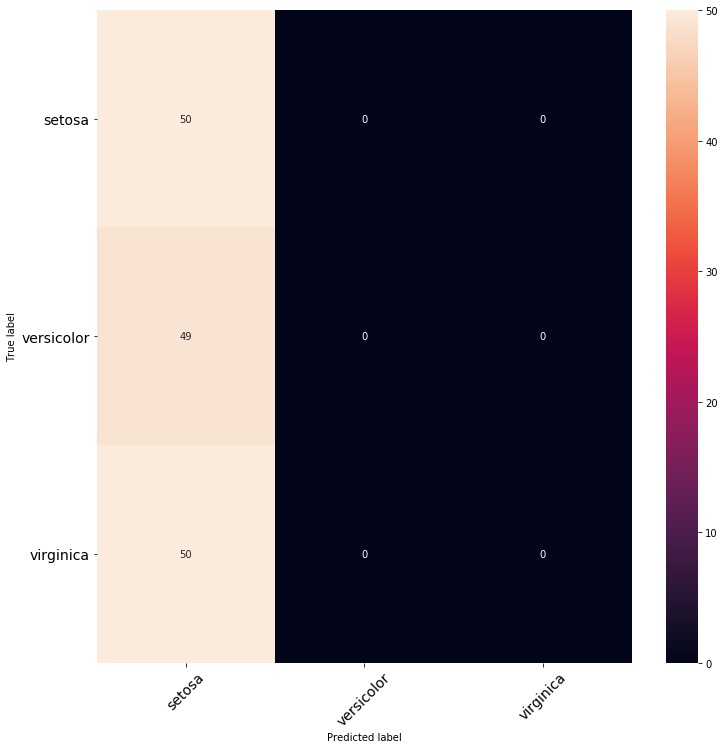

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_cm = pd.DataFrame(confusion_matrix(true_y,predicted_y),
                     index=['setosa','versicolor','virginica'], columns=['setosa','versicolor','virginica'])
plt.figure(figsize=(12,12))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()